In [5]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, AveragePooling2D, Input, Flatten ,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.applications import VGG16
import numpy as np
from matplotlib import pyplot as plt
import os
import time
from numpy.linalg import inv, norm
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split
import pandas as pd
from google.colab import drive

np.set_printoptions(suppress=True, precision=3)
#συνδέσου στο drive
drive.mount('/content/drive')
#πάνε στην directory
os.chdir('/content/drive/MyDrive/extracted_files')
#δημιούργησε την directory για να σώζεις τα μοντέλα
save_dir = os.path.join(os.getcwd(), 'saved_models_VGG16validation')


#τύπος μοντέλου, στην ουσία δώσε ένα όνομα για να προστεθεί στην αρχή του ονόματος του αρχείου
model_type='VGG16meta3L'
# Εκπαίδευση του μοντέλου
#πόσα batch θα φορτώνει το μοντέλο
batch_size = 64
#πόσες εποχές θα τρέξει
epochs = 50
#πόσο θα είναι το ποσοστο που θα χωρίσεις απο τα δεδομένα για validation
split=0.2

#φορτωσε το μοντέλο π.χ '/content/drive/MyDrive/extracted_files/saved_models_VGG16validation/VGG16-0018-loss0.395-accuracy0.836-val_accuracy0.8553.h5'
#εάν το load_weights είναι='' δεν θα φορτώσει κανένα μοντέλο και θα ξεκινήσει την εκπαίδευση απο την αρχή
load_weights=''

# Ορισμός των  φακέλων που βρίσκονται τα δεδομένα για  train και test
train_dir = '/content/drive/MyDrive/extracted_files/train_images'
#test_dir = '/content/drive/MyDrive/extracted_files/test_images'

# Διαβάζουμε το αρχείο labels_train_csv
df = pd.read_csv('/content/drive/MyDrive/extracted_files/labels_train.csv')

# Επιβεβαιώστε ότι οι ετικέτες είναι σε μορφή string
df['class_id'] = df['class_id'].astype(str)


# Διαχωρισμός των δεδομένων σε σετ εκπαίδευσης και δοκιμής
#stratify=y θα υπάρχει ίδια κατανομή στην λίστα y = labels_df['class_id'], για κάθε κλάση στο δείγμα
X_train, X_val, y_train, y_val = train_test_split(df['file_name'], df['class_id'], test_size=split, random_state=42, stratify=df['class_id'])

#δημιούργησε 2 dataframe, train και val
train_df = pd.DataFrame({'file_name': X_train, 'class_id': y_train})
val_df = pd.DataFrame({'file_name': X_val, 'class_id': y_val})

# Εμφάνιση του μεγέθους των σετ εκπαίδευσης και δοκιμής
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_val.shape[0]}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set size: 3737
Test set size: 935


In [6]:
'''
Epoch monitor : Print info at every epoch
'''
#import keras
import csv
from keras.callbacks import Callback
class MyCallback(keras.callbacks.Callback):
    tstart=None
    def on_train_begin(self, logs={}) :
        return

    def on_train_end(self, logs={}) :
        return

    def on_epoch_begin(self, epoch, logs={}) :
        self.tstart = time.time()
        #print('epoch:{:03d}'.format(epoch+1), end=', ')
        return

    def on_epoch_end(self, epoch, logs={}):
        loss = logs.get('loss')
        acc = logs.get('acc')
        val_loss = logs.get('val_loss')
        val_acc = logs.get('val_acc')

        if loss is None or acc is None or val_loss is None or val_acc is None:
            print("Some values are missing. Cannot print metrics.")
            return

        val_acc_minus_acc = 100 * (val_acc - acc) if acc is not None and val_acc is not None else None

        print('loss: {:8.6f}, acc: {:8.6f}, val_loss: {:8.6f}, val_acc: {:8.6f}, val_acc-acc = {:5.2f}%, lr: {:0.6f} [{} sec]'.format(
            loss,
            acc,
            val_loss,
            val_acc,
            val_acc_minus_acc,
            K.eval(self.model.optimizer.lr),
            time.time() - self.tstart
        ))
        return

    def on_batch_begin(self, batch, logs={}) :
        return

    def on_batch_end(self, batch, logs={}) :
        return

class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=0, save_best_only=False):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_val = logs.get(self.monitor)
        if current_val is not None:
            if self.save_best_only:
                if current_val < self.best:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: {self.monitor} improved from {self.best} to {current_val}, saving model and params to {self.filepath}')
                    self.best = current_val
                    self.model.save(self.filepath, overwrite=True)
                    self.save_params(epoch)
            else:
                if self.verbose > 0:
                    print(f'\nEpoch {epoch + 1}: saving model and params to {self.filepath}')
                self.model.save(self.filepath, overwrite=True)
                self.save_params(epoch)

    def save_params(self, epoch):
        with open('training_params.csv', 'a', newline='') as file:
            writer = csv.writer(file)
            # Προσαρμόστε αυτό το μέρος για να περιλαμβάνει όλες τις πληροφορίες που θέλετε να αποθηκεύσετε
            writer.writerow([self.model.name, epoch, batch_size] + list(train_datagen.__dict__.items()))


class SaveBestModelParams(Callback):
    def __init__(self, train_datagen, filepath, header, name, monitor='val_accuracy'):
        super(SaveBestModelParams, self).__init__()
        self.train_datagen=train_datagen
        self.filepath = filepath
        self.monitor = monitor
        self.best = -np.Inf
        self.header = header
        #self.header_written = False
        self.name=name
        if not os.path.exists(filepath):
           with open(self.filepath, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(self.header)  # Γράψτε το header αν το αρχείο δημιουργείται για πρώτη φορά
                #self.header_written = True



    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None:
            if current > self.best:
                self.best = current
                with open(self.filepath, 'a', newline='') as file:
                    writer = csv.writer(file)
                    '''
                    if not self.header_written:
                        writer.writerow(self.header)
                        self.header_written = True
                        #writer = csv.writer(file)
                        '''
                    augmentation_values = [v for k, v in train_datagen.__dict__.items() if k in self.header[3:-4]] # Μόνο τις τιμές για τα κλειδιά που είναι στο header
                    row = [self.name, logs.get('accuracy'), logs.get('loss'), logs.get('val_accuracy'), logs.get('val_loss'), epoch, batch_size] + augmentation_values
                    writer.writerow(row)

                    '''
                    if not self.header_written:
                        writer.writerow(self.header)
                        self.header_written = True
                    row = [self.name, epoch, batch_size] + list(train_datagen.__dict__.items()) + [logs.get('accuracy'), logs.get('loss'), logs.get('val_accuracy'), logs.get('val_loss')]
                    writer.writerow(row)
                    '''


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21204035 (80.89 MB)
Trainable params: 64

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - 292s 5s/step - loss: 1.2214 - accuracy: 0.3257 - val_loss: 1.0888 - val_accuracy: 0.3561 - lr: 5.0000e-07
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.3768
Epoch 2: val_accuracy improved from 0.35615 to 0.46845, saving model to /content/drive/.shortcut-targets-by-id/1PeMz62d6jLXgdlgqoiqqrnIJrxNXZ6zX/extracted_files/saved_models_VGG16validation/VGG16meta3L-0002-loss1.131-accuracy0.377-val_accuracy0.468.h5
59/59 [==============================] - 93s 2s/step - loss: 1.1305 - accuracy: 0.3768 - val_loss: 1.0376 - val_accuracy: 0.4684 - lr: 5.0000e-07
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 1.0915 - accuracy: 0.4306
Epoch 3: val_accuracy improved from 0.46845 to 0.48770, saving model to /content/drive/.shortcut-targets-by-id/1PeMz62d6jLXgdlgqoiqqrnIJrxNXZ6zX/extracted_files/saved_models_VGG16validation/VGG16meta3L-0003-loss1.091-accuracy0.431-val_accuracy0.488.h5
59/59 [========

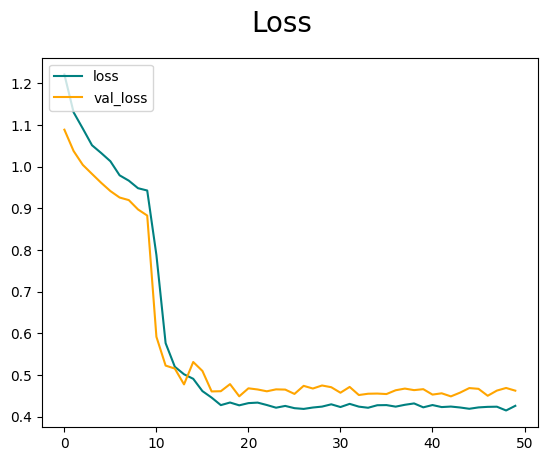

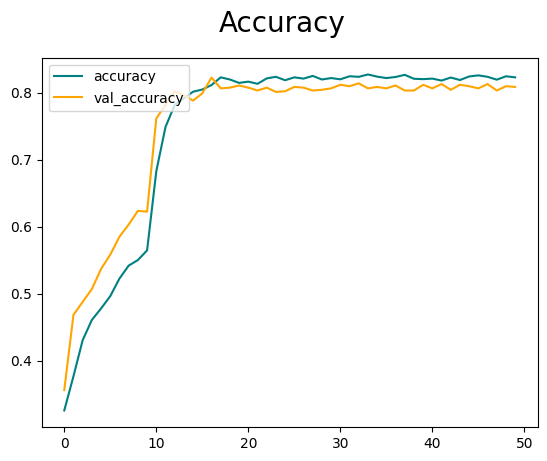

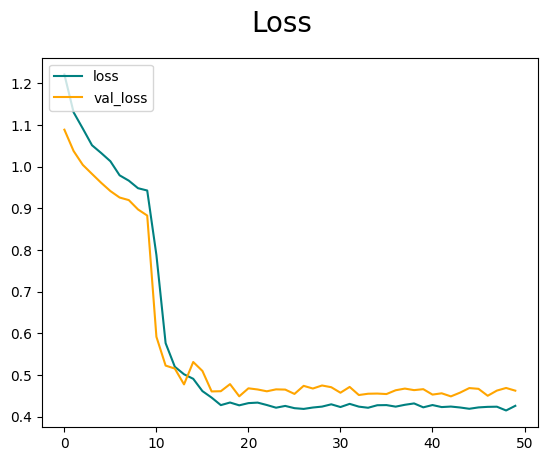

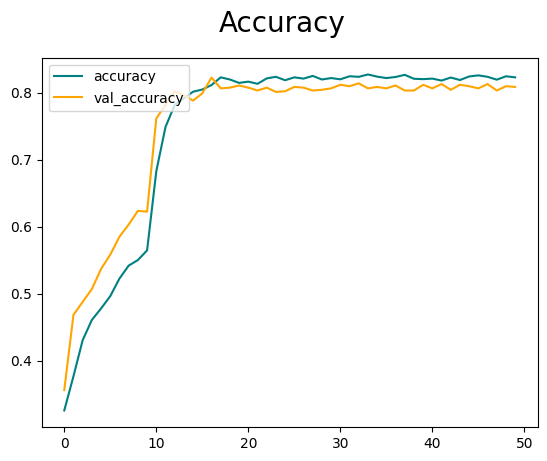

In [7]:
import errno
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import os
import numpy as np



# Συνάρτηση που ορίζει το ρυθμό μάθησης
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 30:
        lr *= 0.5e-3
    elif epoch > 25:
        lr *= 1e-3
    elif epoch > 15:
        lr *= 1e-2
    elif epoch < 10:
        lr *= 0.5e-3
        #lr *= 1e-1
    return lr

# 2η Συνάρτηση που ορίζει το ρυθμό μάθησης
def lr_schedule2(epoch):
  initial_lr = 0.01
  decay_rate = 0.9
  return initial_lr * decay_rate ** epoch


# Δημιουργία του μοντέλου VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Πάγωμα των βαρών του VGG16
base_model.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))  # 3 κλάσεις (πνευμονία, COVID, καθαρός πνεύμονας)


'''
# Πάγωμα των βαρών του VGG16 εκτός των τελευταίων 4
for layer in base_model.layers[-4:]:
    layer.trainable = False

# Ξεπάγωμα των τελευταίων 4 επιπέδων
for layer in base_model.layers[-2:]:
    layer.trainable = True
'''



# Σύνθεση του μοντέλου
model.compile(optimizer=Adam(lr=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])
#φόρτωσε τα βαρη ενός εκπαιδευμένου μοντέλου
if load_weights!='':
  model.load_weights(load_weights)

model.summary()

# Κατάλογος όπου αποθηκεύονται τα μοντέλα
#save_dir = "path_to_model_directory"

# Προετοιμασία του καταλόγου για την αποθήκευση
try:
    os.makedirs(save_dir)
except OSError as e:
    if e.errno == errno.EEXIST:
        print("Directory already exists")
    else:
        raise

# Όνομα με το οποίο θα αποθηκευθεί το μοντέλο
model_name = model_type+'-{epoch:04d}-loss{loss:.3f}-accuracy{accuracy:.3f}-val_accuracy{val_accuracy:.3f}.h5'

# Δημιουργία του διακοπτη για αποθήκευση του μοντέλου κατά τη διάρκεια της εκπαίδευσης
checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, model_name),
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
# Δημιουργία του custom checkpoint callback
custom_checkpoint = CustomModelCheckpoint(filepath=os.path.join(save_dir, model_name),
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_best_only=True)



# Συναρτήσεις μείωσης του ρυθμού μάθησης
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)

# Δημιουργία γεννήτριας δεδομένων
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Κανονικοποίηση των τιμών των pixel
    #preprocessing_function=custom_preprocessing,
    rotation_range=5,           # Περιστροφή εικόνας σε μοίρες
    width_shift_range=0.1,      # Οριζόντια μετατόπιση
    height_shift_range=0.1,     # Κατακόρυφη μετατόπιση
    shear_range=0.1,            # Εφαρμογή τράβηγματος
    zoom_range=0.1,             # Εφαρμογή ζουμ
    #horizontal_flip=True,       # Οριζόντια αντιστροφή εικόνων
    fill_mode='nearest',        # Τρόπος γεμίσματος των νέων pixel που εμφανίζονται μετά τις μετατοπίσεις

    # επιπλέον επιλογές
    vertical_flip=False,        # Κατακόρυφη αντιστροφή
    #brightness_range=[0.7, 1.2],#Τυχαία αλλαγή φωτεινότητας (π.χ. [0.8, 1.2] ή None)
    channel_shift_range=0,    # Τυχαίες αλλαγές στα κανάλια των εικόνων
    featurewise_center=False,   # Κανονικοποίηση κάθε χαρακτηριστικού ξεχωριστά
    samplewise_center=False,    # Κανονικοποίηση κάθε δείγματος ξεχωριστά
    featurewise_std_normalization=False, # Κανονικοποίηση με βάση την τυπική απόκλιση κάθε χαρακτηριστικού
    samplewise_std_normalization=False,  # Κανονικοποίηση με βάση την τυπική απόκλιση κάθε δείγματος
    zca_whitening=False,        # Εφαρμογή ZCA Whitening
    zca_epsilon=1e-06,          # Epsilon τιμή για ZCA Whitening
    #preprocessing_function=None,# Συνάρτηση για πρόσθετη προεπεξεργασία
    data_format=None,           # Τρόπος αναπαράστασης των δεδομένων ('channels_first' ή 'channels_last')
    #validation_split=0.0
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='file_name',
    y_col='class_id',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    #seed=42 τυχαία τιμή για να αναπαράγης τα δεδομένα
    #class_mode='raw'
    )

validation_generator= train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='file_name',
    y_col='class_id',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    #seed=42 #τυχαία τιμή για να αναπαράγης τα δεδομένα
    #class_mode='raw'
    )

# Callback για το διάγραμμα
#plot_callback = LambdaCallback(on_epoch_end=plot_training) βαλτην στα callbacks
#και δημιούργησε μια συνάρτηση plot_training για να την  καλείς
# Εκπαίδευση του μοντέλου

# Αρχικοποίηση της μεταβλητής history
history = None

# Ορίστε το μονοπάτι και το header για το log CSV αρχείο
csv_filepath = 'best_model_params.csv'
csv_header = ['model_name','accuracy', 'loss', 'val_accuracy', 'val_loss', 'epoch', 'batch_size'] + list(train_datagen.__dict__.keys())
# Δημιουργήστε το SaveBestModelParams callback
save_best_model_params = SaveBestModelParams(train_datagen, filepath=csv_filepath, header=csv_header, name=model_type)
try:

  history = model.fit(train_generator, epochs=epochs, workers=4, verbose=1,
                    callbacks=[lr_reducer, lr_scheduler, checkpoint, save_best_model_params], validation_data=validation_generator )
  fig = plt.figure()
  plt.plot(history.history['loss'], color='teal', label='loss')
  plt.plot(history.history['val_loss'], color='orange', label='val_loss')
  fig.suptitle('Loss', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()
  fig = plt.figure()
  plt.plot(history.history['accuracy'], color='teal', label='accuracy')
  plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
  fig.suptitle('Accuracy', fontsize=20)
  plt.legend(loc="upper left")
  plt.show()

except KeyboardInterrupt:
      print("Training manually interrupted")

if history is not None and 'loss' in history.history:
    # Εμφάνιση των γραφημάτων, εφόσον υπάρχουν διαθέσιμα δεδομένα
    fig = plt.figure()
    plt.plot(history.history['loss'], color='teal', label='loss')
    plt.plot(history.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    fig = plt.figure()
    plt.plot(history.history['accuracy'], color='teal', label='accuracy')
    plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print("No training data available for plotting.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
